In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Settings

mpl.rcParams.update({
    "legend.fancybox": False
})

colors = {
    'blue': '#0077b5',
    'pink': '#de00a5',
    'salmon': '#ff4a6e',
    'purple': '#8700cd',
    'green': '#45cc37',
    'yellow': '#fecb51',
    'gray': '#727377',
    'lightgray': '#ced1db'
}

grad = [(0,colors['salmon']), 
        (.33,colors['lightgray']), 
        (1,colors['blue'])]
grad = mpl.colors.LinearSegmentedColormap.from_list('custom', grad)

In [23]:
# Load data
ratio_model = pd.read_csv('tate/ratio_model.csv', index_col=0).rename(columns={"model": "ratio_model"})
collection = pd.read_csv("tate/paintings.csv", index_col=0)
collection = collection.join(ratio_model)

collection

,artist,title,year,groundtruth,height,width,ratio_model
T13896,John Constable,Salisbury Cathedral from the Meadows,1831,L,1537,1920,L
T05010,Pablo Picasso,Weeping Woman,1937,O,608,500,O
N05915,Pablo Picasso,Bust of a Woman,1909,P,727,600,O
N00530,Joseph Mallord William Turner,Snow Storm - Steam-Boat off a Harbour’s Mouth,1842,L,914,1219,L
T00598,Richard Dadd,The Fairy Feller’s Master-Stroke,1855,O,540,394,P
...,...,...,...,...,...,...,...
N05609,Maurice Sterne,Mexican Church Interior,1934,O,1283,1022,P
T14823,Unknown artist,Leon Trotsky,1980,P,510,480,O
AL00397,Louise Bourgeois,Untitled,1946,O,660,1116,L
T14824,Unknown artist,Leon Trotsky,1980,P,638,511,O


In [27]:
from collections import Counter
titles = collection['title'].str.lower()

wordcount = Counter()
for t in titles:
    for w in t.split():
        if len(w) >= 2:
            wordcount[w] += 1
    
remove = ['the', 'and', 'with', 'from', 'for', 'untitled', 'of', 'in', 'at', 'on', 'an', 'st', 'to', 'by']
for w in remove:
    wordcount[w] = 0
    
port_words = {'portrait', 'nude', 'bust', 'self-portrait', 'figure',
                'gentleman', 'mr', 'lord', 'count', 'sir', 'man', 'boy', 
                'dr', 'colonel',
                'mrs', 'miss', 'lady', 'dame', 'countess', 'duchess', 'woman', 'women', 'girl', 
                'husband', 'wife', 'father', 'mother', 'son', 'daughter', 'family',
                'brother', 'sister', 'child'}
land_words = {'view', 'landscape', 'house', 'church', 'mill',
              'church', 'cathedral', 'castle', 
              'bridge', 'river', 'lake', 'canal', 'channel', 'pier', 'harbour', 'thames',
              'boat', 'ship', 'beach', 'sea', 'bay', 'coast', 'cliff',
              'tree', 'flower', 'forest', 'wood', 'garden', 'park', 'meadow', 'field', 'farm',
              'mountain', 'hill', 
              'morning', 'evening', 'sunset', 'sunrise',
              'winter', 'summer', 'autumn', 'spring'}

iport = titles.str.contains('|'.join(port_words))
iland = titles.str.contains('|'.join(land_words)) 
irest = iport & iland
iport &= ~irest
iland &= ~irest

collection['title_model'] = 'O'
collection.loc[iland,'title_model'] = 'L'
collection.loc[iport,'title_model'] = 'P'

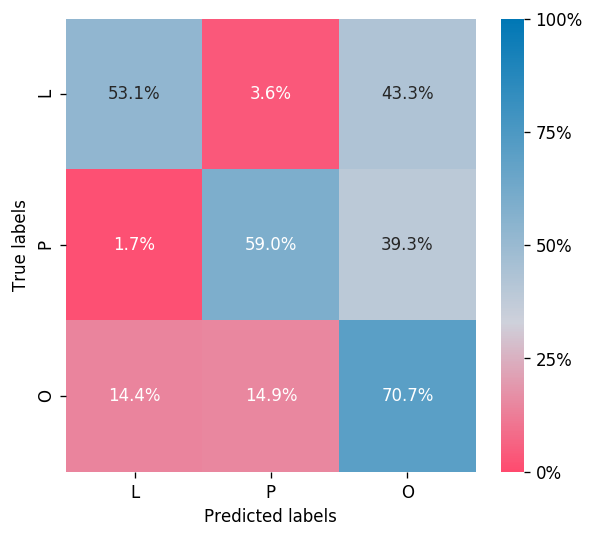

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

truth = collection['groundtruth']
pred = collection['title_model']
C = confusion_matrix(truth, pred, labels=['L','P','O'], normalize='true')

fig, ax = plt.subplots(figsize=(5.5,5), dpi=120)
sns.heatmap(C, annot=True, fmt='.1%', ax=ax, cmap=grad, vmin=0, vmax=1) 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['L', 'P', 'O']);
ax.yaxis.set_ticklabels(['L', 'P', 'O'])

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

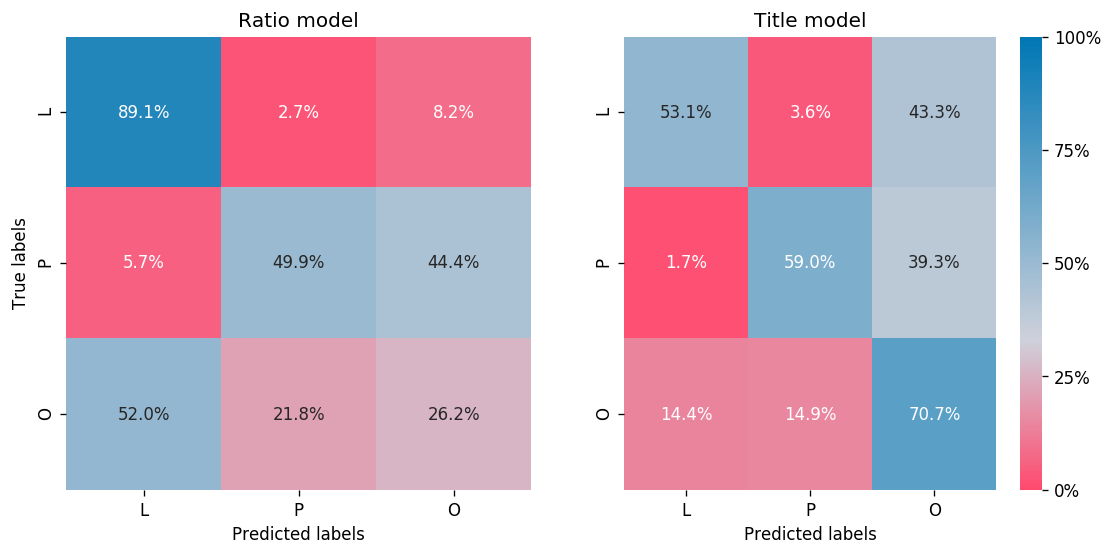

In [45]:
truth = collection['groundtruth']

fig, axes = plt.subplots(1, 2, figsize=(11,5), dpi=120)
for model, ax, bar in zip(['ratio_model', 'title_model'], axes, [False, True]):
    pred = collection[model]
    C = confusion_matrix(truth, pred, labels=['L','P','O'], normalize='true')

    sns.heatmap(C, annot=True, fmt='.1%', ax=ax, cmap=grad, vmin=0, vmax=1, cbar=bar) 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.xaxis.set_ticklabels(['L', 'P', 'O']);
    ax.yaxis.set_ticklabels(['L', 'P', 'O'])
    ax.set_title(model.replace("_", " ").capitalize())

axes[0].set_ylabel('True labels'); 
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

In [30]:
collection[['title_model']].to_csv('tate/title_model.csv')